<a href="https://colab.research.google.com/github/robertheubanks/newaiengbootcamp/blob/main/Eubanks_Week_4_Homework_8_Creating_a_LlamaIndex_RAG_Pipeline_with_NL2SQL_and_Metadata_Filtering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a LlamaIndex RAG Pipeline with NL2SQL and Metadata Filtering!

We'll be putting together a system for querying both qualitative and quantitative data using LlamaIndex.

The acitvities will be broken down as follows:

- 🤝 Breakout Room #1
  - Task 1: Load Dependencies
  - Task 2: Set Env Variables and Set Up WandB Callback
  - Task 3: Initialize Settings
  - Task 4: Semantic RAG Pipeline with Metadata Filtering
- 🤝 Breakout Room #2
  - Task 1: Quantitative RAG Pipeline with NL2SQL Tooling
  - Task 2: Combined RAG Pipeline

Before we get started, however, a quick note on terminology.


### A note on terminology:

You'll notice that there are quite a few similarities between LangChain and LlamaIndex. LlamaIndex can largely be thought of as an extension to LangChain, in some ways - but they moved some of the language around. Let's spend a few moments disambiguating the language.

- `QueryEngine` -> `LCEL Chain`:
  -  `QueryEngine` is just LlamaIndex's way of indicating something is an LLM "chain" on top of a retrieval system
- `OpenAIAgent` vs. `Agent`:
  - The two agents have the same fundamental pattern: Decide which of a list of tools to use to answer a user's query.
  - `OpenAIAgent` (LlamaIndex's primary agent) does not need to rely on an agent excecutor due to the fact that it is leveraging OpenAI's [functional api](https://openai.com/blog/function-calling-and-other-api-updates) which allows the agent to interface "directly" with the tools instead of operating through an intermediary application process.

There is, however, a much large terminological difference when it comes to discussing data.

##### Nodes vs. Documents

As you're aware of from the previous weeks assignments, there's an idea of `documents` in NLP which refers to text objects that exist within a corpus of documents.

LlamaIndex takes this a step further and reclassifies `documents` as `nodes`. Confusingly, it refers to the `Source Document` as simply `Documents`.

The `Document` -> `node` structure is, almost exactly, equivalent to the `Source Document` -> `Document` structure found in LangChain - but the new terminology comes with some clarity about different structure-indices.

We won't be leveraging those structured indicies today, but we will be leveraging a "benefit" of the `node` structure that exists as a default in LlamaIndex, which is the ability to quickly filter nodes based on their metadata.

![image](https://i.imgur.com/B1QDjs5.png)

# 🤝 Breakout Room #1

## BOILERPLATE

This is only relevant when running the code in a Jupyter Notebook.

In [ ]:
import nest_asyncio

nest_asyncio.apply()

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Task 1: Load Dependencies

Let's grab our core `llama-index` library, as well as OpenAI's Python SDK.

We'll be leveraging OpenAI's suite of APIs to power our RAG pipelines today.

> NOTE: You can safely ignore any pip errors that occur during the running of these cells.

In [ ]:
!pip install -qU llama-index openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.1/286.1 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

We'll be using [Weights and Biases](https://docs.wandb.ai/guides/prompts) (WandB) again for today's notebook!

In [ ]:
!pip install -qU wandb llama-index-callbacks-wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


We'll be collecting our semantic data from Wikipedia - and so will need the [Wikipedia Reader](https://github.com/run-llama/llama_index/tree/main/llama-index-integrations/readers/llama-index-readers-wikipedia)!

In [ ]:
!pip install -qU wikipedia llama-index-readers-wikipedia

  Preparing metadata (setup.py) ... done


Our vector database today will be powered by [ChromaDB](https://github.com/chroma-core/chroma) and so we'll need that package as well!

In [ ]:
!pip install -qU chromadb llama-index-vector-stores-chroma

Finally, we'll need to grab a few dependencies related to our quantitative data!

In [ ]:
!pip install -q -U sqlalchemy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 24.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


We'll grab some additional miscellaneous dependencies here.

In [ ]:
!pip install -U -q tiktoken==0.4.0 sentence-transformers==2.2.2 pydantic==1.10.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.6 MB/s eta 0:00:00


## Task 2: Set Env Variables and Set Up WandB Callback

Let's set our API keys for both OpenAI and WandB!

In [ ]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

OpenAI API Key: ··········


In [ ]:
os.environ["WANDB_API_KEY"] = getpass.getpass("WandB API Key: ")

WandB API Key: ··········


We'll also need to set a callback handler for WandB to ensure smooth operation of our traces!

In [ ]:
import llama_index
from llama_index.core import set_global_handler

set_global_handler("wandb", run_args={"project": "aie1-llama-index-demo"})
wandb_callback = llama_index.core.global_handler

wandb: Streaming LlamaIndex events to W&B at https://wandb.ai/robertheubanks/aie1-llama-index-demo/runs/m7lvd3bu
wandb: `WandbCallbackHandler` is currently in beta.
wandb: Please report any issues to https://github.com/wandb/wandb/issues with the tag `llamaindex`.


### Task 3: Settings

LlamaIndex lets us set global settings which we can use to influence the default behaviour of our components.

Let's set our LLM and our Embedding Model!

In [ ]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

Settings.llm = OpenAI(model="gpt-3.5-turbo")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

## Task 4: Semantic RAG Pipeline with Metadata Filtering

Now we can get to work creating our semantic `QueryEngine`!

We'll start, as we normally do, by grabbing some data.

> NOTE: Remember that a query engine is just a different word for a chain!

### Data Collection

We're just going to be pulling information straight from Wikipedia using the built in `WikipediaReader`.

> NOTE: Setting `auto_suggest=False` ensures we run into fewer auto-correct based errors.

In [ ]:
from llama_index.readers.wikipedia import WikipediaReader

movie_list = ["Dune (2021 film)", "Dune: Part Two"]

wiki_docs = WikipediaReader().load_data(pages=movie_list, auto_suggest=False)

### Initializing our VectorStoreIndex with ChromaDB

ChromaDB is a locally hostable and open-source vector database solution.

It offers powerful features like metadata filtering out of the box, and will suit our needs well today!

We'll start by creating our local `EphemeralClient()` (in-memory and not meant for production use-cases) and our collection.

Then we'll create our `VectorStore` and `StorageContext` which will allow us to create an empty `VectorStoreIndex` which we will be able to add nodes to later!

In [ ]:
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb

chroma_client = chromadb.EphemeralClient()
chroma_collection = chroma_client.create_collection("dune-v0")

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.core import StorageContext

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents([], storage_context=storage_context)

wandb: Logged trace tree to W&B.


### Node Construction

Now we will loop through our documents and metadata and construct nodes.

We'll make sure to explicitly associate our nodes with their respective movie so we can filter by the movie title in the upcoming cells.

> NOTE: You can safely ignore any WARNINGs in the following cell.

In [ ]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.extractors import TitleExtractor

pipeline = IngestionPipeline(transformations=[TokenTextSplitter()])

for movie, wiki_doc in zip(movie_list, wiki_docs):
    nodes = pipeline.run(documents=wiki_docs)
    for node in nodes:
        node.metadata = {"title" : movie}
    index.insert_nodes(nodes)

Insert of existing embedding ID: 414c4e06-7cea-4cd8-b083-b1923f84c39c


Insert of existing embedding ID: 7446e4f2-309f-4a5d-80c1-2aec358c6467


Insert of existing embedding ID: feacc665-976f-4bed-904d-1b7f6000f05d


Insert of existing embedding ID: b4c25294-7a69-4379-bc9b-4804ec66dacf


Insert of existing embedding ID: bcfcce44-e848-4704-8e9c-fc6ed899d32a


Insert of existing embedding ID: f8281b37-784b-4e67-999f-eb19b59ee594


Insert of existing embedding ID: d2a51890-61ff-43c2-8178-51dcca851852


Insert of existing embedding ID: 5c4cf897-70c3-497b-96da-ac4f214c7045


Insert of existing embedding ID: 9789f32c-273f-481c-a403-d4b6845275f7


Insert of existing embedding ID: 1b682faf-c55f-4bff-94cf-0c264f9f4a4b


Insert of existing embedding ID: b84338ed-948b-41c9-9de6-e544a885e03b


Insert of existing embedding ID: 8f25d221-47f8-4eac-a39b-cb777e107583


Insert of existing embedding ID: 2043b739-ae96-4287-bcff-bfdacb8541e4


Insert of existing embedding ID: 8e306c0b-4091-4fbf-81ac-fa5221f6cb33


Insert of existing embedding ID: e129aec2-7483-4f6f-a677-8dc470d924b7


Insert of existing embedding ID: 8f7a3dfa-27e9-4014-8942-2e22d2475112


Insert of existing embedding ID: cce0badc-6735-427a-91e4-9793e54a61da


Insert of existing embedding ID: 1de9eacd-1f0e-40a2-a8e4-e98c5d896a0a


Insert of existing embedding ID: 94bcfe72-dc8a-4481-ab76-4680443bf4de


Insert of existing embedding ID: 49874d58-0ed6-42fc-9f41-8cbf98db4a9f


Insert of existing embedding ID: 013ba63c-5d78-4ad5-b11c-cf4ffc12d9ac


Add of existing embedding ID: 414c4e06-7cea-4cd8-b083-b1923f84c39c


Add of existing embedding ID: 7446e4f2-309f-4a5d-80c1-2aec358c6467


Add of existing embedding ID: feacc665-976f-4bed-904d-1b7f6000f05d


Add of existing embedding ID: b4c25294-7a69-4379-bc9b-4804ec66dacf


Add of existing embedding ID: bcfcce44-e848-4704-8e9c-fc6ed899d32a


Add of existing embedding ID: f8281b37-784b-4e67-999f-eb19b59ee594


Add of existing embedding ID: d2a51890-61ff-43c2-8178-51dcca851852


Add of existing embedding ID: 5c4cf897-70c3-497b-96da-ac4f214c7045


Add of existing embedding ID: 9789f32c-273f-481c-a403-d4b6845275f7


Add of existing embedding ID: 1b682faf-c55f-4bff-94cf-0c264f9f4a4b


Add of existing embedding ID: b84338ed-948b-41c9-9de6-e544a885e03b


Add of existing embedding ID: 8f25d221-47f8-4eac-a39b-cb777e107583


Add of existing embedding ID: 2043b739-ae96-4287-bcff-bfdacb8541e4


Add of existing embedding ID: 8e306c0b-4091-4fbf-81ac-fa5221f6cb33


Add of existing embedding ID: e129aec2-7483-4f6f-a677-8dc470d924b7


Add of existing embedding ID: 8f7a3dfa-27e9-4014-8942-2e22d2475112


Add of existing embedding ID: cce0badc-6735-427a-91e4-9793e54a61da


Add of existing embedding ID: 1de9eacd-1f0e-40a2-a8e4-e98c5d896a0a


Add of existing embedding ID: 94bcfe72-dc8a-4481-ab76-4680443bf4de


Add of existing embedding ID: 49874d58-0ed6-42fc-9f41-8cbf98db4a9f


Add of existing embedding ID: 013ba63c-5d78-4ad5-b11c-cf4ffc12d9ac


####❓ Question #1:

What `metadata` fields will the nodes in our index have?

Please write the code to find this information.

In [ ]:
### YOUR CODE HERE
unique_metadata_keys = set()
for node in index.nodes:
    if node.metadata:  # Checking if the metadata dictionary exists and is not empty
        unique_metadata_keys.update(node.metadata.keys())

print(unique_metadata_keys)

### Persisting and Loading Stored Index with Weights and Biases

Now we can utilize a powerful feature of Weights and Biases - index and artifact versioning!

We can persist our index to WandB to be used and loaded later!

In [ ]:
wandb_callback.persist_index(index, index_name="dune-index-chromadb")

wandb: Adding directory to artifact (/content/wandb/run-20240308_005341-m7lvd3bu/files/storage)... Done. 0.0s


Now we can load our index from WandB, which is a truly powerful tool!

In [ ]:
from llama_index.core import load_index_from_storage

storage_context = wandb_callback.load_storage_context(
    artifact_url="robertheubanks/aie1-llama-index-demo/dune-index-chromadb:v0"
)

wandb:   4 of 4 files downloaded.  


####❓ Question #2:

Provide a screenshot of your index version history as shown in WandB.

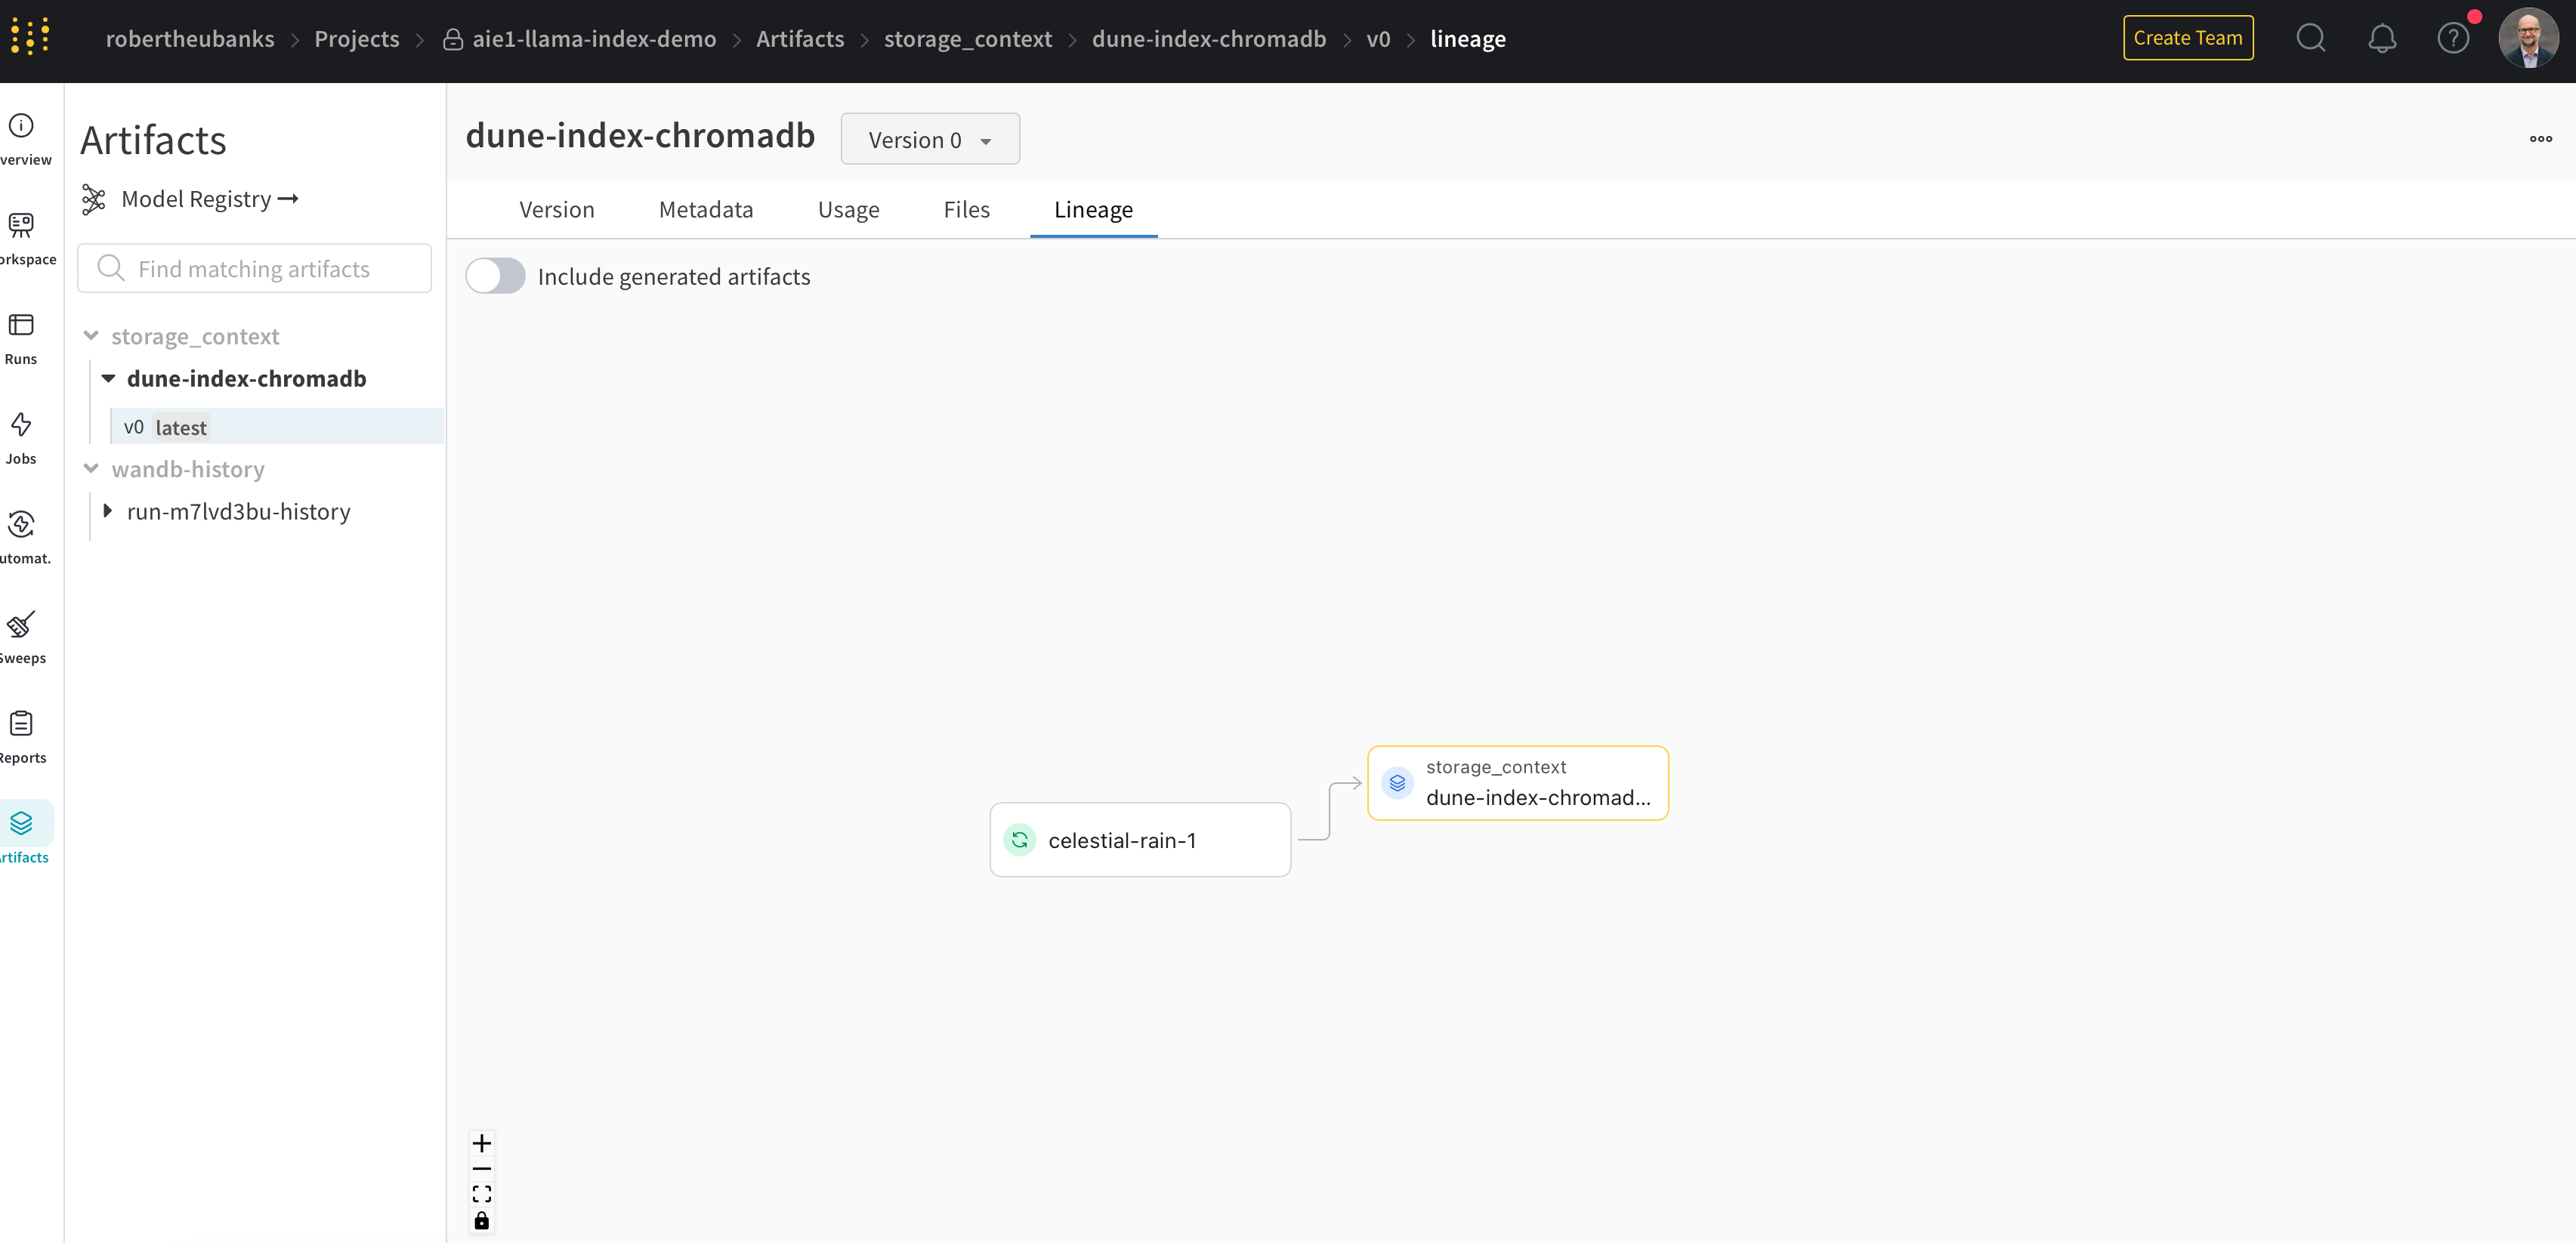

### Auto Retriever Functional Tool

This tool will leverage OpenAI's functional endpoint to select the correct metadata filter and query the filtered index - only looking at nodes with the desired metadata.

A simplified diagram: ![image](https://i.imgur.com/AICDPav.png)

First, we need to create our `VectoreStoreInfo` object which will hold all the relevant metadata we need for each component (in this case title metadata).

Notice that you need to include it in a text list.

In [ ]:
from llama_index.core.tools import FunctionTool
from llama_index.core.vector_stores.types import (
    VectorStoreInfo,
    MetadataInfo,
    ExactMatchFilter,
    MetadataFilters,
)
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

from typing import List, Tuple, Any
from pydantic import BaseModel, Field

top_k = 3

vector_store_info = VectorStoreInfo(
    content_info="semantic information about movies",
    metadata_info=[MetadataInfo(
        name="title",
        type="str",
        description="title of the movie, one of ['Dune (2021 film)', 'Dune: Part 2']",
    )]
)

Now we'll create our base PyDantic object that we can use to ensure compatability with our application layer. This verifies that the response from the OpenAI endpoint conforms to this schema.

In [ ]:
class AutoRetrieveModel(BaseModel):
    query: str = Field(..., description="natural language query string")
    filter_key_list: List[str] = Field(
        ..., description="List of metadata filter field names"
    )
    filter_value_list: List[str] = Field(
        ...,
        description=(
            "List of metadata filter field values (corresponding to names specified in filter_key_list)"
        )
    )

Now we can build our function that we will use to query the functional endpoint.

In [ ]:
def auto_retrieve_fn(
    query: str, filter_key_list: List[str], filter_value_list: List[str]
):
    """Auto retrieval function.

    Performs auto-retrieval from a vector database, and then applies a set of filters.

    """
    query = query or "Query"

    exact_match_filters = [
        ExactMatchFilter(key=k, value=v)
        for k, v in zip(filter_key_list, filter_value_list)
    ]
    retriever = VectorIndexRetriever(
        index, filters=MetadataFilters(filters=exact_match_filters), top_k=top_k
    )
    query_engine = RetrieverQueryEngine.from_args(retriever)

    response = query_engine.query(query)
    return str(response)

Now we need to wrap our system in a tool in order to integrate it into the larger application.

Source Code Here:
- [`FunctionTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/function_tool.py#L21)

In [ ]:
description = f"""\
Use this tool to look up semantic information about films.
The vector database schema is given below:
{vector_store_info.json()}
"""

auto_retrieve_tool = FunctionTool.from_defaults(
    fn=auto_retrieve_fn,
    name="semantic-film-info",
    description=description,
    fn_schema=AutoRetrieveModel
)

####❓ Question #3:

Is the text in the description of our `FunctionTool` important or not? Please explain your answer.

ANSWER:
The text in the description of the FunctionTool plays a crucial role in user interaction and usability, especially in the context of integrating AI and software tools within larger application ecosystems. The importance of this text can be analyzed from several perspectives:

*   User Understanding: The description serves as a guide for users on how to use the tool effectively. By providing clear, descriptive information about the tool's purpose—such as looking up semantic information about films—it helps users understand what the tool does and when to use it. This is especially important for tools that might be used by a diverse group of users with varying levels of technical expertise.
*   Documentation: From a documentation standpoint, the description acts as an inline documentation for the tool. It can improve the maintainability of the software by providing context directly where it's needed, reducing the need for external documentation.
*   Integration and Automation: For developers or systems integrating this tool into larger workflows, the description provides essential information about the tool's capabilities and its data schema. This is particularly important for automated systems that rely on metadata to understand the role and output of each component in a pipeline.
*   User Experience (UX): The description enhances the user experience by setting clear expectations for what the tool can do. A well-crafted description can lead to better user satisfaction by preventing confusion and misuse of the tool.
*   Compliance and Accessibility: In some contexts, having clear descriptions and documentation built into the tool can also be a compliance requirement, ensuring that all users have the necessary information to use the software safely and effectively. It also contributes to the accessibility of the tool by making it more approachable and understandable.

All that's left to do is attach the tool to an OpenAIAgent and let it rip!

Source Code Here:
- [`OpenAIAgent`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/agent/openai_agent.py#L361)

In [ ]:
from llama_index.agent.openai import OpenAIAgent

agent = OpenAIAgent.from_tools(
    tools=[auto_retrieve_tool],
    verbose=True,
)

In [ ]:
response = agent.chat("Who starred in the 2021 film?")
print(str(response))

Added user message to memory: Who starred in the 2021 film?
=== Calling Function ===
Calling function: semantic-film-info with args: {"query":"cast of Dune (2021 film)","filter_key_list":["title"],"filter_value_list":["Dune (2021 film)"]}
Got output: The cast of "Dune" (2021 film) includes Timothée Chalamet as Paul "Muad'Dib" Atreides, Zendaya as Chani, Rebecca Ferguson as Lady Jessica, Josh Brolin as Gurney Halleck, Austin Butler as Feyd-Rautha Harkonnen, Florence Pugh as Princess Irulan, Dave Bautista as Glossu Rabban Harkonnen, Christopher Walken as Shaddam IV, Léa Seydoux as Lady Margot Fenring, Souheila Yacoub as Shishakli, Stellan Skarsgård as Baron Vladimir Harkonnen, Charlotte Rampling as Gaius Helen Mohiam, and Javier Bardem as Stilgar.



wandb: Logged trace tree to W&B.


The cast of the 2021 film "Dune" includes Timothée Chalamet, Zendaya, Rebecca Ferguson, Josh Brolin, Austin Butler, Florence Pugh, Dave Bautista, Christopher Walken, Léa Seydoux, Souheila Yacoub, Stellan Skarsgård, Charlotte Rampling, and Javier Bardem.


# 🤝 Breakout Room #2

## Task 1: Quantitative RAG Pipeline with NL2SQL Tooling

We'll walk through the steps of creating a natural language to SQL system in the following section.

> NOTICE: This does not have parsing on the inputs or intermediary calls to ensure that users are using safe SQL queries. Use this with caution in a production environment without adding specific guardrails from either side of the application.

The next few steps should be largely straightforward, we'll want to:

1. Read in our `.csv` files into `pd.DataFrame` objects
2. Create an in-memory `sqlite` powered `sqlalchemy` engine
3. Cast our `pd.DataFrame` objects to the SQL engine
4. Create an `SQLDatabase` object through LlamaIndex
5. Use that to create a `QueryEngineTool` that we can interact with through the `NLSQLTableQueryEngine`!

If you get stuck, please consult the documentation.

In [ ]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv

--2024-03-08 01:23:28--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133391 (130K) [text/plain]
Saving to: ‘dune1.csv’

dune1.csv           100%[===================>] 130.26K  --.-KB/s    in 0.01s   

2024-03-08 01:23:28 (8.62 MB/s) - ‘dune1.csv’ saved [133391/133391]



In [ ]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv

--2024-03-08 01:23:32--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111843 (109K) [text/plain]
Saving to: ‘dune2.csv’

dune2.csv           100%[===================>] 109.22K  --.-KB/s    in 0.02s   

2024-03-08 01:23:32 (6.39 MB/s) - ‘dune2.csv’ saved [111843/111843]



#### Read `.csv` Into Pandas

In [ ]:
import pandas as pd

dune1_df = pd.read_csv("./dune1.csv")
dune2_df = pd.read_csv("./dune2.csv")

#### Create SQLAlchemy engine with SQLite

In [ ]:
from sqlalchemy import create_engine

engine = create_engine("sqlite+pysqlite:///:memory:")

#### Convert `pd.DataFrame` to SQL tables

In [ ]:
dune1_df.to_sql(
    "Dune (2021 film)",
    engine
)

274

In [ ]:
dune2_df.to_sql(
    "Dune: Part 2",
    engine
)

175

#### Construct a `SQLDatabase` index

Source Code Here:
- [`SQLDatabase`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/langchain_helpers/sql_wrapper.py#L9)

In [ ]:
from llama_index.core import SQLDatabase

sql_database = SQLDatabase(
    engine=engine,
    include_tables=["Dune (2021 film)", "Dune: Part 2"]
)

#### Create the NLSQLTableQueryEngine interface for all added SQL tables

Source Code Here:
- [`NLSQLTableQueryEngine`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/indices/struct_store/sql_query.py#L75C1-L75C1)

In [ ]:
from llama_index.core.indices.struct_store.sql_query import NLSQLTableQueryEngine

sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["Dune (2021 film)", "Dune: Part 2"],
)

#### Wrap It All Up in a `QueryEngineTool`

You'll want to ensure you have a descriptive...description.

An example is provided here:

```
Useful for translating a natural language query into a SQL query over a table containing:
John Wick 1, containing information related to reviews of the first John Wick movie, called John Wick
John Wick 2, containing information related to reviews of the second John Wick movie, called John Wick: Chapter 2
John Wick 3, containing information related to reviews of the third John Wick movie, called John Wick: Chatper 3 - Parabellum
John Wick 4, containing information related to reviews of the fourth John Wick movie, called John Wick: Chatper 4
```

Sorce Code Here:

- [`QueryEngineTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/query_engine.py#L13)

####🏗️ Activity #1:

Please write a Natural Language Description for the tables that we are using today.

In [ ]:
DESCRIPTION = """\
This dataset comprises two tables related to the Dune film series, specifically focusing on the "Dune (2021 film)" and its sequel "Dune: Part 2". Each table contains detailed information pertinent to the respective films, including cast lists, character names, plot summaries, release dates, box office earnings, and critical reception metrics. These tables serve as a foundation for translating natural language queries into SQL queries, facilitating an intuitive search experience for users interested in exploring various facets of these films. Whether you're seeking to analyze the films' performance metrics, research the characters and their portrayals, or investigate the narrative elements and how they evolve from the first to the second movie, these tables offer a structured way to query and retrieve this information efficiently.
"""

In [ ]:
from llama_index.core.tools.query_engine import QueryEngineTool

sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql-query",
    description=DESCRIPTION,
)

In [ ]:
agent = OpenAIAgent.from_tools(
    tools=[sql_tool],
    verbose=True
)

In [ ]:
response = agent.chat("What is the average rating of the 2nd Dune movie?")

Added user message to memory: What is the average rating of the 2nd Dune movie?
=== Calling Function ===
Calling function: sql-query with args: {"input":"SELECT AVG(rating) AS average_rating FROM dune_movies WHERE movie_title = 'Dune: Part 2'"}
Got output: The average rating for "Dune: Part 2" is 8.71.



wandb: Logged trace tree to W&B.


In [ ]:
print(str(response))

The average rating for the 2nd Dune movie, "Dune: Part 2," is 8.71.


### Task 2: Combined RAG Pipeline

Now, we can simply add our tools into the `OpenAIAgent`, and off we go!

In [ ]:
dune_agent = OpenAIAgent.from_tools(
    tools=[auto_retrieve_tool, sql_tool],
    verbose=True
)

In [ ]:
response = dune_agent.chat("What is the lowest rating of the 1st film?")

Added user message to memory: What is the lowest rating of the 1st film?
=== Calling Function ===
Calling function: sql-query with args: {"input":"SELECT MIN(rating) FROM dune_films WHERE title = 'Dune (2021 film)'"}
Got output: The minimum rating for the film "Dune (2021 film)" is not available in the database.



wandb: Logged trace tree to W&B.


In [ ]:
print(str(response))

The lowest rating for the film "Dune (2021 film)" is not available in the database.


In [ ]:
response = dune_agent.chat("What planet does the 1st Dune movie take place on?")

Added user message to memory: What planet does the 1st Dune movie take place on?
=== Calling Function ===
Calling function: semantic-film-info with args: {"query":"planet where the 1st Dune movie takes place","filter_key_list":["title"],"filter_value_list":["Dune (2021 film)"]}
Got output: Arrakis



wandb: Logged trace tree to W&B.


In [ ]:
print(str(response))

The first Dune movie takes place on the planet Arrakis.


In [ ]:
response = dune_agent.chat("Calculate the average review of each movie - and then discuss how the average review changed over time.")

Added user message to memory: Calculate the average review of each movie - and then discuss how the average review changed over time.
=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT AVG(rating) as avg_rating, title FROM dune_films GROUP BY title"}
Got output: There seems to be an error in the SQL query provided. It is not a valid SQL statement. Please review the syntax and try again.

=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT release_date, AVG(rating) as avg_rating FROM dune_films GROUP BY release_date ORDER BY release_date"}
Got output: There seems to be an error in the SQL query provided. It appears that the statement is invalid. Please review the syntax and try running the query again.

=== Calling Function ===
Calling function: sql-query with args: {"input":"SELECT AVG(rating) as avg_rating, title FROM dune_films GROUP BY title"}
Got output: There seems to be an error in the SQL query provided. It appears tha

wandb: Logged trace tree to W&B.


In [ ]:
print(str(response))

There was an error in retrieving the average reviews for each movie and analyzing the change over time. Let me correct the query and try again.


####❓ Question #4:

How can you verify which tool was used for which query?

ANSWER:
To verify which tool was used for which query within the context of an OpenAIAgent setup that handles multiple tools (like auto_retrieve_tool and sql_tool), you can follow a structured approach based on the design and verbose outputs of the system. When using the OpenAIAgent with the verbose=True setting, the agent provides detailed output about its operations, including which tools are called for each query. Here's how you can verify which tool was used for a particular query:

*   Verbose Output: As shown in the provided code snippets, when the verbose parameter is set to True in the OpenAIAgent.from_tools() method, the agent logs detailed information about its interactions, including which function (tool) is called and with what arguments. This output is your primary source of information for determining which tool was invoked for a given query.

*   Tool Invocation Details: In the verbose output, look for the section labeled "Calling Function". This section will explicitly state the name of the function (and by extension, the tool) that is being called, along with the provided arguments. For example, the output might include a line like Calling function: sql-query with args: {...}, indicating that the sql_tool was used for processing the query related to SQL operations.

*   Response Analysis: By analyzing the content and context of the response, you can infer which tool was likely used. For instance, if the query is about retrieving semantic information and the response includes specific details that would come from the semantic database, you can deduce that the semantic-film-info tool was used. Conversely, if the query involves data manipulation or retrieval that requires SQL operations and the response indicates interaction with a database, it's clear that the sql_tool was employed.
*   Tool Configuration and Capabilities: Understanding the configuration and capabilities of each tool integrated into the OpenAIAgent can also help you identify which tool was used. Each tool is designed for specific types of queries or data interactions. For example, auto_retrieve_tool might be configured to handle semantic information retrieval, while sql_tool is set up for SQL database queries. Knowing what each tool does can help you match the query with the tool's purpose.
*   Log and Trace Tools: If your system or the OpenAIAgent framework supports additional logging or tracing (like the mentioned wandb: Logged trace tree to W&B), these tools can provide deeper insights into the execution flow, including which tool was invoked for each query. These logs or traces might offer a more granular view of the system's internal operations.

In [ ]:
wandb_callback.finish()